# Modelling trend life cycles in scientific research

**Authors:** E. Tattershall, G. Nenadic, and R.D. Stevens

**Abstract:** Scientific topics vary in popularity over time. In this paper, we model the life-cycles of 200 topics by fitting the Logistic and Gompertz models to their frequency over time in published abstracts. Unlike other work, the topics we use are algorithmically extracted from large datasets of abstracts covering computer science, particle physics, cancer research, and mental health. We find that the Gompertz model produces lower median error, leading us to conclude that it is the more appropriate model. Since the Gompertz model is asymmetric, with a steep rise followed a long tail, this implies that scientific topics follow a similar trajectory. We also explore the case of double-peaking curves and find that in some cases, topics will peak multiple times as interest resurges. Finally, when looking at the different scientific disciplines, we find that the lifespan of topics is longer in some disciplines (e.g. cancer research and mental health) than it is others, which may indicate differences in research process and culture between these disciplines. 


**Requirements**
- Data. Data ingress is excluded from this notebook, but we alraedy have four large datasets of abstracts. The documents in these datasets have been cleaned (described in sections below) and separated by year. Anecdotally, this method works best when there are >100,000 documents in the dataset (and more is even better).
- The other utility files in this directory, including burst_detection.py, my_stopwords.py, etc...

**In this notebook** 

- Vectorisation
- Burst detection
- Clustering
- Model fitting
- Comparing the error of the two models
- Calculating trend duration 
- Double peaked curves
- Trends and fitted models in full

In [1]:
import os
import csv
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import numpy as np
import scipy
from scipy.spatial.distance import squareform
from scipy.cluster import hierarchy
import pickle

import burst_detection
import my_stopwords
import cleaning
import tools
import logletlab

import scipy.optimize as opt
from sklearn.metrics import mean_squared_error



In [2]:
stop = my_stopwords.get_stopwords()
burstiness_threshold = 0.004
cluster_distance_threshold = 7

# Burst detection internal parameters
# These are the same as in our earlier paper [Tattershall 2020]
parameters = {
    "min_yearly_df": 5,
    "significance_threshold": 0.0015,
    "years_above_significance": 3,
    "long_ma_length": 8,
    "short_ma_length": 4,
    "signal_line_ma": 3,
    "significance_ma_length": 3        
}

# Number of bursty terms to extract for each dataset. This will later be filtered down to 50 for each dataset after clustering.
max_bursts = 300

dataset_names = ['pubmed_mh', 'arxiv_hep', 'pubmed_cancer', 'dblp_cs']
dataset_titles = ['Computer science (dblp)', 'Particle physics (arXiv)', 'Mental health (PubMed)', 'Cancer (PubMed)']
datasets = {}

def reverse_cumsum(ls):
    reverse = np.zeros_like(ls)
    for i in range(len(ls)):
        if i == 0:
            reverse[i] = ls[i]
        else:
            reverse[i] = ls[i]-ls[i-1]
            
            
    if reverse[0]>reverse[1]:
        reverse[0]=reverse[1]
            
    return reverse

def detransform_fit(ypc, F, dataset_name):
    '''
    The Gompertz and Logistic curves actually model *cumulative* frequency over time, not raw frequency. 
    However, raw frequency is more intuitive for graphs, so we use this function to change a cumulative 
    time series into a non-cumulative one. Additionally, the models were originally fitted to scaled curves
    (such that the minumum frequency was zero and the maximum was one). This was done to make it possible to 
    directly compare the error between different time series without a much more frequent term dwarfing the calculation.
    We now transform back.
    '''
    s = document_count_per_year[dataset_name]
    yf = reverse_cumsum(F*(max(ypc)-min(ypc)) + min(ypc))
    return yf


In [ ]:
# Location where the cleaned data is stored
data_root = 'cleaned_data/'

# Location where we will store the results of this notebook
root = 'results/'

os.mkdir(root+'clusters')
os.mkdir(root+'images')
os.mkdir(root+'fitted_curves')
os.mkdir(root+'vectors')

for dataset_name in dataset_names:
    os.mkdir(root+'vectors/'+dataset_name)
    os.mkdir(root+'fitted_curves/'+dataset_name)

## The data

We have four  datasets:

- **Computer Science (dblp_cs):** This dataset contains 2.6 million abstracts downloaded from Semantic Scholar. We select all abstracts with the dblp tag.
- **Particle Physics (arxiv_hep):** This dataset of 0.2 million abstracts was downloaded from arXiv's public API. We extracted particle physics-reladed documents by selecting everything under the categroies hep-ex, hep-lat, hep-ph and hep-th.
- **Mental Health (pubmed_mh):** 0.7 million abstracts downloaded from PubMed. This dataset was created by filtering on the MeSH keyword "Mental Health" and all its subterms.
- **Cancer (pubmed_cancer):** 1.9 million abstracts downloaded from PubMed. This dataset was created by filtering on the MeSH keyword "Neoplasms" and all its subterms.

The data in each dataset has already been cleaned. We removed punctuation, set all characters to lowercase and lemmatised each word using WordNetLemmatizer. The cleaned data is stored in pickled pandas dataframes in files named 1988.p, 1989.p, 1990.p. Each dataframe has a column "cleaned" which contains the cleaned and lemmatized text for each document in that dataset in the given year. 

### How many documents are in each dataset in each year?

In [21]:
document_count_per_year = {}

for dataset_name in dataset_names:
    # For each dataset, we want a list of document counts for each year
    document_count_per_year[dataset_name] = []
    # The files in the directory are named 1988.p, 1989.p, 1990.p....
    files = os.listdir(data_root+dataset_name)
    min_year = np.min([int(file[0:4]) for file in files])
    max_year = np.max([int(file[0:4]) for file in files])
    
    for year in range(min_year, max_year+1):
        df = pickle.load(open(data_root+dataset_name+'/'+str(year)+'.p', "rb"))
        document_count_per_year[dataset_name].append(len(df))
        
pickle.dump(document_count_per_year, open(root + 'document_count_per_year.p', "wb"))

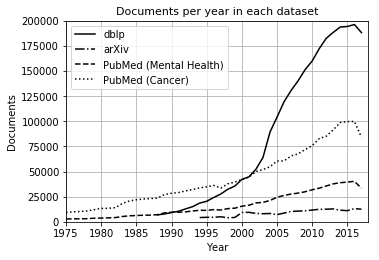

In [22]:
plt.figure(figsize=(6,3.7))
ax1=plt.subplot(111)
plt.subplots_adjust(left=0.2, right=0.9)
ax1.set_title('Documents per year in each dataset', fontsize=11)

ax1.plot(np.arange(1988, 2018), document_count_per_year['dblp_cs'], 'k', label='dblp')
ax1.plot(np.arange(1994, 2018), document_count_per_year['arxiv_hep'], 'k', linestyle= '-.', label='arXiv')
ax1.plot(np.arange(1975, 2018), document_count_per_year['pubmed_mh'], 'k', linestyle= '--', label='PubMed (Mental Health)')
ax1.plot(np.arange(1975, 2018), document_count_per_year['pubmed_cancer'], 'k', linestyle= ':', label='PubMed (Cancer)')
ax1.grid()


ax1.set_xlim([1975, 2018])
ax1.set_ylabel('Documents', fontsize=10)
ax1.set_xlabel('Year', fontsize=10)
ax1.set_ylim([0,200000])
ax1.legend(fontsize=10)

plt.savefig(root+'images/documents_per_year.eps', format='eps', dpi=1200)

### Create a vocabulary for each dataset

- For each dataset, we find all **1-5 word terms** (after stopwords are removed). This allows us to use relatively complex phrases.
- Since the set of all 1-5 word terms is very large and contains much noise, we filter out terms that fail to meet a **minimum threshold of "significance"**. For significance we require that they occur at least six times in at least one year. We find that this also gets rid of spelling erros and cuts down the size of the data.


In [10]:
for dataset_name in dataset_names:
    vocabulary = set()

    files = os.listdir(data_root+dataset_name)
    min_year = np.min([int(file[0:4]) for file in files])
    max_year = np.max([int(file[0:4]) for file in files])
    
    for year in range(min_year, max_year+1):
        df = pickle.load(open(data_root+dataset_name+"/"+str(year)+".p", "rb"))
        # Create an initial vocabulary based on the list of text files
        vectorizer = CountVectorizer(strip_accents='ascii', 
                                     ngram_range=(1,5),
                                     stop_words=stop,
                                     min_df=6
                                    )
        
        # Vectorise the data in order to get the vocabulary
        vector = vectorizer.fit_transform(df['cleaned'])
        
        # Add the harvested vocabulary to the set. This removes duplicates of terms that occur in multiple years
        vocabulary = vocabulary.union(set(vectorizer.vocabulary_))
        
        # To conserve memory, delete the vector here
        del vector
        
    print('Overall vocabulary created for ', dataset_name)
        
    # We now vectorise the dataset again based on the unifying vocabulary
    vocabulary = list(vocabulary)
    vectors = []
    vectorizer = CountVectorizer(strip_accents='ascii', 
                                 ngram_range=(1,5),
                                 stop_words=stop,
                                 vocabulary=vocabulary)
    
    for year in range(min_year, max_year+1):
        df = pickle.load(open(data_root+dataset_name+"/"+str(year)+".p", "rb"))
        vector = vectorizer.fit_transform(df['cleaned'])
        
        # Set all elements of the vector that are greater than 1 to 1. This is because we only care about
        # the overall document frequency of each term. If a word is used multiple times in a single document
        # it only contributes 1 to the document frequency.
        vector[vector>1] = 1
        
        # Sum the vector along its columns in order to get the total document frequency of each term in a year
        summed = np.squeeze(np.asarray(np.sum(vector, axis=0)))
        
        vectors.append(summed)
        
    # Turn the vector into a pandas dataframe
    df = pd.DataFrame(vectors, columns=vocabulary) 

    # THE PART BELOW IS OPTIONAL
    # We found that the process works better if very similar terms are removed from the vocabulary
    # Therefore, for each 2-5 ngram, we identify all possible subterms, then attempt to calculate whether
    # the subterms are legitimate terms in their own right (i.e. they appear in documents without their
    # superterm parent). For example, the term "long short-term memory" is made up of the subterms
    # ["long short", "short term", "term memory", "long short term", "short term memory"]
    # However, when we calculate the document frequency of each subterm divided by the document frequency of 
    # "long short term memory", we find:
    #    
    # long short 1.4
    # short term 6.1
    # term memory 2.2
    # long short term 1.1
    # short term memory 1.4
    #
    # Since the term "long short term" occurs only very rarely outside the phrase "long short term memory", we 
    # omit this term by setting an arbitrary threshold of 1.1. This preserves most of the subterms while removing the rarest.
        
    removed = []
    
    # for each term in the vocabulary
    for i, term in enumerate(list(df.columns)):
        # If the term is a 2-5 ngram (i.e. not a single word)
        if ' ' in term:
            # Find the overall term document frequency over the entire dataset
            term_total_document_frequency = df[term].sum()
            
            # Find all possible subterms of the term. 
            subterms = tools.all_subterms(term)
            
            for subterm in subterms:
                try:
                    # If the subterm is in the vocabulary, check whether it often occurs on its own
                    # without the superterm being present
                    subterm_total_document_frequency = df[subterm].sum()
                    if subterm_total_document_frequency < term_total_document_frequency*1.1:
                        removed.append([subterm, term])

                except:
                    pass

    # Remove the removed terms from the dataframe
    df = df.drop(list(set([r[0] for r in removed])), axis=1)
    
    
    # END OPTIONAL PART
    
    # Store the stacked vectors for later use
    pickle.dump(df, open(root+'vectors/'+dataset_name+"/stacked_vector.p", "wb"))
    pickle.dump(list(df.columns), open(root+'vectors/'+dataset_name+"/vocabulary.p", "wb"))

Overall vocabulary created for  arxiv_hep


### Detect bursty terms

Now that we have vectors representing the document frequency of each term over time, we can use our MACD-based burst detection, as described in our earlier paper [Tattershall 2020]. 

In [12]:
bursts = dict()
for dataset_name in dataset_names:

    files = os.listdir(data_root+dataset_name)
    min_year = np.min([int(file[0:4]) for file in files])
    max_year = np.max([int(file[0:4]) for file in files])
    
    # Create a dataset object for the burst detection algorithm
    bd_dataset = burst_detection.Dataset(
        name = dataset_name, 
        years = (min_year, max_year), 
        # We divide the term-document frequency for each year by the number of documents in that year 
        stacked_vectors = pickle.load(open(root+dataset_name+"/stacked_vector.p", "rb")).divide(document_count_per_year[dataset_name],axis=0)
    )
    
    # We apply the significance threshold from the burst detection methodology. This cuts the size of the dataset by 
    # removing terms that occur only in one year
    bd_dataset.get_sig_stacked_vectors(parameters["significance_threshold"], parameters["years_above_significance"])
    bd_dataset.get_burstiness(parameters["short_ma_length"], parameters["long_ma_length"], parameters["significance_ma_length"], parameters["signal_line_ma"])
    datasets[dataset_name] = bd_dataset
    bursts[dataset_name] = tools.get_top_n_bursts(datasets[dataset_name].burstiness, max_bursts)
    
pickle.dump(bursts, open(root+'vectors/'+'bursts.p', "wb"))

### Calculate burst co-occurence 

We now have 300 bursts per dataset. Some of these describe very similar concepts, such as "internet of things" and "iot". The purpose of this section is the merge similar terms into clusters to prevent redundancy within the dataset. We calculate the relatedness of terms using term co-occurrence within the same document (terms that appear together are grouped together).

In [13]:
for dataset_name in dataset_names:
    vectors = []
    vectorizer = CountVectorizer(strip_accents='ascii', 
                                 ngram_range=(1,5),
                                 stop_words=stop,
                                 vocabulary=bursts[dataset_name])
    
    for year in range(min_year, max_year+1):
        df = pickle.load(open(data_root+dataset_name+"/"+str(year)+".p", "rb"))
        vector = vectorizer.fit_transform(df['cleaned'])
        
        # Set all elements of the vector that are greater than 1 to 1. This is because we only care about
        # the overall document frequency of each term. If a word is used multiple times in a single document
        # it only contributes 1 to the document frequency.
        vector[vector>1] = 1
        
        vectors.append(vector)
        
    # Calculate the cooccurrence matrix
    v = vectors[0]
    c = v.T*v
    c.setdiag(0)
    c = c.todense()

    cooccurrence = c

    for v in vectors[1:]:
        c = v.T*v
        c.setdiag(0)
        c = c.toarray()
        cooccurrence += c
    
    pickle.dump(cooccurrence, open(root+'vectors/'+dataset_name+"/cooccurrence_matrix.p", "wb"))

C:\Users\emmat\Anaconda3\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
C:\Users\emmat\Anaconda3\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


### Use burst co-occurrence to cluster terms

We use a hierarchichal clustering method to group terms together. This is highly customisable due to threshold setting, allowing us to group more or less conservatively if required.

In [16]:
# Reload bursts if required by uncommenting this line
#bursts = pickle.load(open(root+'bursts.p', "rb"))

dataset_clusters = dict()
for dataset_name in dataset_names:
    #cooccurrence = pickle.load(open('Data/stacked_vectors/'+dataset_name+"/cooccurrence_matrix.p", "rb"))
    
    # Translate co-occurence into a distance
    dists = np.log(cooccurrence+1).max()- np.log(cooccurrence+1)

    # Remove the diagonal (squareform requires diagonals be zero)
    dists -= np.diag(np.diagonal(dists))

    # Put the distance matrix into the format required by hierachy.linkage
    flat_dists = squareform(dists)

    # Get the linkage matrix
    linkage_matrix = hierarchy.linkage(flat_dists, "ward")

    assignments = hierarchy.fcluster(linkage_matrix, t=cluster_distance_threshold, criterion='distance')

    clusters = defaultdict(list)  
    
    for term, assign, co in zip(bursts[dataset_name], assignments, cooccurrence):
        clusters[assign].append(term)

    dataset_clusters[dataset_name] = list(clusters.values())

In [17]:
dataset_clusters['arxiv_hep'] 

[['125 gev', '125 gev higgs', 'gev higgs', 'gev higgs boson'],
 ['pentaquark', 'pentaquarks', 'theta', 'exotic', 'exotic baryon', 'narrow'],
 ['wmap', 'wmap data'],
 ['sqrts tev',
  'collision sqrts tev',
  'sqrts',
  'pp collision',
  'pp collision sqrts tev',
  'pp collision sqrts',
  'collision sqrts',
  'pp',
  'inverse femtobarns',
  'atlas detector',
  'integrated luminosity',
  'collected',
  'luminosity',
  'corresponding integrated luminosity',
  'detector lhc',
  'proton proton'],
 ['run', 'lhc run', 'run ii', 'lhc run ii'],
 ['pamela', 'fermi', 'pamela fermi', 'positron', 'positron excess'],
 ['lattice',
  'lattice gauge',
  'lattice gauge theory',
  'simulation',
  'continuum'],
 ['tensor scalar',
  'tensor scalar ratio',
  'planck',
  'planck data',
  'inflation',
  'spectral index',
  'inflaton',
  'n_s'],
 ['brane',
  'branes',
  'bps',
  'dual',
  'string',
  'duality',
  'supergravity',
  'iib',
  'modulus',
  'string theory'],
 ['atlas', 'cm', 'excess', 'diphoton', 'a

### Manual choice of clusters

We now sort the clusters in order of burstiness (using the burstiness of the most bursty term in the cluster) and manually exclude clusters that include publishing artefacts such as "elsevier science bv right reserved". From the remainder, we select the top fifty. We do this for all four datasets, giving 200 clusters. The selected clusters are stored in the file "200clusters.csv".

### For each cluster, create a time series of mentions in abstracts over time

We now need to search for the clusters to pull out the frequency of appearance in abstracts over time. For the cluster ["Internet of things", "IoT"], all abstracts that mention **either** term are included (i.e. an abstract that uses "Internet of things" without the abbreviation "IoT" still counts towards the total for that year). We take document frequency, not term frequency, so the number of times the terms are mentioned in each document do not matter, so long as they are mentioned once.

In [25]:
raw_clusters = pd.read_csv('200clusters.csv')
cluster_dict = defaultdict(list)
for dataset_name in dataset_names:
    for raw_cluster in raw_clusters[dataset_name]:
        cluster_dict[dataset_name].append(raw_cluster.split(','))
        

for dataset_name in dataset_names:
    # List all the cluster terms. This will be more than the total number of clusters.
    all_cluster_terms = sum(cluster_dict[dataset_name], [])

    # Get the cluster titles. This is the list of terms in each cluster
    all_cluster_titles = [','.join(cluster) for cluster in cluster_dict[dataset_name]]

    # Get a list of files from the directory
    files = os.listdir(data_root + dataset_name)

    # This is where we will store the data. The columns correspond to clusters, the rows to years
    prevalence_array = np.zeros([len(files),len(cluster_dict[dataset_name])])

    # Open each year file in turn
    for i, file in enumerate(files):
        print(file)
        year_data = pickle.load(open(data_root + dataset_name + '/' + file, 'rb'))

        # Vectorise the data for that year
        vectorizer = CountVectorizer(strip_accents='ascii', 
                             ngram_range=(1,5),
                             stop_words=stop,
                             vocabulary=all_cluster_terms
                            )

        vector = vectorizer.fit_transform(year_data['cleaned'])


        # Get the index of each cluster term. This will allows us to map the full vocabulary 
        # e.g. (60 items) back onto the original clusters (e.g. 50 items)
        for j, cluster in enumerate(cluster_dict[dataset_name]):
            indices = []
            for term in cluster:
                indices.append(all_cluster_terms.index(term))

                # If there are multiple terms in a cluster, sum the cluster columns together
                summed_column = np.squeeze(np.asarray(vector[:,indices].sum(axis=1).flatten()))
                # Set any element greater than one to one--we're only counting documents here, not 
                # total occurrences
                summed_column[summed_column!=0] = 1

                # This is the total number of occurrences of the cluster per year
                prevalence_array[i, j] = np.sum(summed_column)

        # Save the data
        df = pd.DataFrame(data=prevalence_array, index=[f[0:4] for f in files], columns=all_cluster_titles) 
        pickle.dump(df, open(root+'clusters/'+dataset_name+'.p', 'wb'))

1994.p
1995.p
1996.p
1997.p
1998.p
1999.p
2000.p
2001.p
2002.p
2003.p
2004.p
2005.p
2006.p
2007.p
2008.p
2009.p
2010.p
2011.p
2012.p
2013.p
2014.p
2015.p
2016.p
2017.p


### Curve fitting


The below is a pythonic version of the Loglet Lab 4 code found at https://github.com/pheguest/logletlab4. Loglet Lab also has a web interface at https://logletlab.com/ which allows you to create amazing graphs. However, the issue with the web interface is that it is not designed for processing hundreds of time series, and in order to do this, each time series must be laboriously copy-pasted into the input box, the parameters set, and then the results saved individually. With 200 time series and multiple parameter sets, this process is quite slow! Therefore, we have adapted the code from the github repository, but the original should be seen at https://github.com/pheguest/logletlab4/blob/master/javascript/src/psmlogfunc3.js. 


In [8]:
curve_header_1 = ['', 'd', 'k', 'a', 'b', 'RMS']
curve_header_2 = ['', 'd', 'k1', 'a1', 'b1', 'k2', 'a2', 'b2', 'RMS']
dataset_names = ['arxiv_hep', 'pubmed_mh', 'pubmed_cancer', 'dblp_cs']

for dataset_name in dataset_names:
    print('-'*50)
    print(dataset_name.upper())
    
    for curve_type in ['logistic', 'gompertz']:
        for number_of_peaks in [1, 2]:
            with open('our_loglet_lab/'+dataset_name+'/'+curve_type+str(number_of_peaks)+'.csv', 'w', newline='') as f:
                writer = csv.writer(f)
                if number_of_peaks == 1:
                    writer.writerow(curve_header_1)
                elif number_of_peaks == 2:
                    writer.writerow(curve_header_2)                    

            df = pickle.load(open(root+'clusters/'+dataset_name+'.p', 'rb'))
            document_count_per_year = pickle.load(open(root+"/document_count_per_year.p", 'rb'))[dataset_name]
            df = df.divide(document_count_per_year, axis=0)

            for term in df.keys():
                y = tools.normalise_time_series(df[term].cumsum())
                x = np.array([int(i) for i in y.index])
                y = y.values


                if number_of_peaks == 1:
                    logobj = logletlab.LogObj(x, y, 1)
                    constraints = logletlab.estimate_constraints(x, y, 1)

                    if curve_type == 'logistic':
                        logobj = logletlab.loglet_MC_anneal_regression(logobj, constraints=constraints, number_of_loglets=1, 
                                                             curve_type='logistic', anneal_iterations=20, 
                                                             mc_iterations=1000, anneal_sample_size=100)
                    else:
                        logobj = logletlab.loglet_MC_anneal_regression(logobj, constraints=constraints, number_of_loglets=1, 
                                                             curve_type='gompertz', anneal_iterations=20, 
                                                             mc_iterations=1000, anneal_sample_size=100)  

                    line = [term, logobj.parameters['d'], logobj.parameters['k'][0], logobj.parameters['a'][0], logobj.parameters['b'][0], logobj.energy_best]

                    print(curve_type, number_of_peaks, term, 'RMSE='+str(np.round(logobj.energy_best,3)))
                    with open(root+'fitted_curves/'+dataset_name+'/'+curve_type+'_single.csv', 'a', newline='') as f:
                        writer = csv.writer(f)
                        writer.writerow(line)  

                elif number_of_peaks == 2:
                    logobj = logletlab.LogObj(x, y, 2)
                    constraints = logletlab.estimate_constraints(x, y, 2)

                    if curve_type == 'logistic':
                        logobj = logletlab.loglet_MC_anneal_regression(logobj, constraints=constraints, number_of_loglets=2, 
                                                             curve_type='logistic', anneal_iterations=30, 
                                                             mc_iterations=1000, anneal_sample_size=100)
                    else:
                        logobj = logletlab.loglet_MC_anneal_regression(logobj, constraints=constraints, number_of_loglets=2, 
                                                             curve_type='gompertz', anneal_iterations=30, 
                                                             mc_iterations=1000, anneal_sample_size=100)  

                    line = [term, logobj.parameters['d'], 
                            logobj.parameters['k'][0], 
                            logobj.parameters['a'][0], 
                            logobj.parameters['b'][0], 
                            logobj.parameters['k'][1], 
                            logobj.parameters['a'][1], 
                            logobj.parameters['b'][1], 
                            logobj.energy_best]

                    print(curve_type, number_of_peaks, term, 'RMSE='+str(np.round(logobj.energy_best,3)))
                
                    with open(root+'fitted_curves/'+dataset_name+'/'+curve_type+'_double.csv', 'a', newline='') as f:
                        writer = csv.writer(f)
                        writer.writerow(line) 

--------------------------------------------------
ARXIV_HEP
logistic_single 1 125 gev 0.029907304762336263
logistic_single 1 pentaquark,pentaquarks 0.05043852824061915
logistic_single 1 wmap,wilkinson microwave anisotropy probe 0.0361380293123339
logistic_single 1 lhc run 0.020735398919035756
logistic_single 1 pamela 0.03204821466738317
logistic_single 1 lattice gauge 0.05233359007692712
logistic_single 1 tensor scalar ratio 0.036222971357601726
logistic_single 1 brane,branes 0.03141774013518978
logistic_single 1 atlas 0.01772382630535608
logistic_single 1 horava lifshitz,hovrava lifshitz 0.0410067585251185
logistic_single 1 lhc 0.006250825571034508
logistic_single 1 noncommutative,noncommutativity,non commutative,non commutativity 0.0327322808924473
logistic_single 1 black hole 0.020920939530327295
logistic_single 1 anomalous magnetic moment 0.04849255402257149
logistic_single 1 unparticle,unparticles 0.03351932242115829
logistic_single 1 superluminal 0.061748625288615105
logistic_si

gompertz_single 2 anomalous magnetic moment RMSE=0.017
gompertz_single 2 unparticle,unparticles RMSE=0.07
gompertz_single 2 superluminal RMSE=0.03
gompertz_single 2 m2 brane,m2 branes RMSE=0.031
gompertz_single 2 126 gev RMSE=0.093
gompertz_single 2 pp wave RMSE=0.022
gompertz_single 2 lambert RMSE=0.061
gompertz_single 2 tevatron RMSE=0.024
gompertz_single 2 higgs RMSE=0.009
gompertz_single 2 brane world RMSE=0.023
gompertz_single 2 extra dimension RMSE=0.01
gompertz_single 2 entropic RMSE=0.029
gompertz_single 2 kamland RMSE=0.016
gompertz_single 2 solar neutrino RMSE=0.012
gompertz_single 2 neutrino oscillation RMSE=0.008
gompertz_single 2 chern simon RMSE=0.014
gompertz_single 2 forward backward asymmetry RMSE=0.021
gompertz_single 2 dark energy RMSE=0.006
gompertz_single 2 bulk RMSE=0.007
gompertz_single 2 holographic RMSE=0.009
gompertz_single 2 international linear collider,ilc RMSE=0.012
gompertz_single 2 abjm RMSE=0.056
gompertz_single 2 babar RMSE=0.007
gompertz_single 2 daya

FileNotFoundError: [Errno 2] No such file or directory: 'our_loglet_lab/pubmed_mh/logistic_single1.csv'

## Reload the data

The preceding step is very long, and may take many hours to complete. Therefore, since we did it in chunks, we now reload the results from memory.

In [4]:
# Load the data back up (since the steps above store the results in files, not local memory)
document_count_per_year = pickle.load(open(root+'document_count_per_year.p', "rb"))
    
datasets = {}
for dataset_name in dataset_names:
    datasets[dataset_name] = {}
    for curve_type in ['logistic', 'gompertz']:
        datasets[dataset_name][curve_type] = {}
        for peaks in ['single', 'double']:
            df = pd.read_csv(root+'fitted_curves/'+dataset_name+'/'+curve_type+'_'+peaks+'.csv', index_col=0)
            datasets[dataset_name][curve_type][peaks] = df

### Graph: Example single-peaked fit for XML

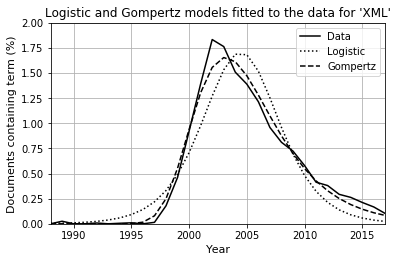

In [5]:
x = range(1988,2018)
term = 'xml'

# Load the original time series for xml
df = pickle.load(open(root+'clusters/dblp_cs.p', 'rb'))
# Divide the data for each year by the document count in each year
y_proportional = df[term].divide(document_count_per_year['dblp_cs'])


# Calculate Logistic and Gompertz curves from the parameters estimated earlier
y_logistic = logletlab.calculate_series(x, 
                datasets['dblp_cs']['logistic']['single']['a'][term],
                datasets['dblp_cs']['logistic']['single']['k'][term],
                datasets['dblp_cs']['logistic']['single']['b'][term],
                'logistic'
               )
# Since the fitting was done with a normalised version of the curve, we detransform it back into the original scale
y_logistic = detransform_fit(y_proportional.cumsum(), y_logistic, 'dblp_cs')


y_gompertz = logletlab.calculate_series(x, 
                datasets['dblp_cs']['gompertz']['single']['a'][term],
                datasets['dblp_cs']['gompertz']['single']['k'][term],
                datasets['dblp_cs']['gompertz']['single']['b'][term],
                'gompertz'
               )
y_gompertz = detransform_fit(y_proportional.cumsum(), y_gompertz, 'dblp_cs')


plt.figure(figsize=(6,3.7))
# Multiply by 100 so that values will be percentages
plt.plot(x, 100*y_proportional, label='Data', color='k')
plt.plot(x, 100*y_logistic, label='Logistic', color='k', linestyle=':')
plt.plot(x, 100*y_gompertz, label='Gompertz', color='k', linestyle='--')
plt.legend()
plt.grid()
plt.title("Logistic and Gompertz models fitted to the data for 'XML'", fontsize=12)
plt.xlim([1988,2017])
plt.ylim(0,2)
plt.ylabel("Documents containing term (%)", fontsize=11)
plt.xlabel("Year", fontsize=11)
           
plt.savefig(root+'images/xmlexamplefit.eps', format='eps', dpi=1200)

### Table of results for Logistic vs Gompertz

Compare the error of the Logistic and Gompertz models across the entire dataset of 200 trends.

In [6]:
def statistics(df):
    mean = df.mean()
    ci = 1.96*logistic_error.std()/np.sqrt(len(logistic_error))
    median = df.median()
    std = df.std()
    
    return [mean, mean-ci, mean+ci, median, std]

logistic_error = pd.concat([datasets['arxiv_hep']['logistic']['single']['RMS'], 
           datasets['dblp_cs']['logistic']['single']['RMS'], 
           datasets['pubmed_mh']['logistic']['single']['RMS'], 
           datasets['pubmed_cancer']['logistic']['single']['RMS']])

gompertz_error = pd.concat([datasets['arxiv_hep']['gompertz']['single']['RMS'], 
           datasets['dblp_cs']['gompertz']['single']['RMS'], 
           datasets['pubmed_mh']['gompertz']['single']['RMS'], 
           datasets['pubmed_cancer']['gompertz']['single']['RMS']])


print('Logistic')

mean = logistic_error.mean()
ci = 1.96*logistic_error.std()/np.sqrt(len(logistic_error))

print('Mean =', np.round(mean,3))
print('95% CI = [', np.round(mean-ci, 3), ',', np.round(mean+ci, 3), ']')
print('Median =', np.round(logistic_error.median(), 3))
print('STDEV =', np.round(logistic_error.std(), 3))
print('')

print('Gompertz')

mean = gompertz_error.mean()
ci = 1.96*gompertz_error.std()/np.sqrt(len(logistic_error))

print('Mean =', np.round(mean,3))
print('95% CI = [', np.round(mean-ci, 3), ',', np.round(mean+ci, 3), ']')
print('Median =', np.round(gompertz_error.median(), 3))
print('STDEV =', np.round(gompertz_error.std(), 3))


Logistic
Mean = 0.029
95% CI = [ 0.027 , 0.031 ]
Median = 0.029
STDEV = 0.014

Gompertz
Mean = 0.023
95% CI = [ 0.021 , 0.026 ]
Median = 0.019
STDEV = 0.017


### Is the difference between the means significant?

Here we use an independent t-test to investigate significance.

In [7]:
scipy.stats.ttest_ind(logistic_error, gompertz_error, axis=0, equal_var=True, nan_policy='propagate')

Ttest_indResult(statistic=3.9283690112124683, pvalue=0.000100810354924735)

Yes, it is significant! However, since the data is slightly skewed, we can also test the signficance of the difference between medians using Mood's median test:

In [8]:
stat, p, med, tbl = scipy.stats.median_test(logistic_error, gompertz_error)
print(p)

1.1980742802127062e-08


So either way, the p-value is very low, causing us to reject the null hypothesis. This leads us to the conclusion that the **Gompertz model** is more appropriate for the task of modelling publishing activity over time.

### Box and whisker plots of Logistic and Gompertz model error

(0, 0.12)

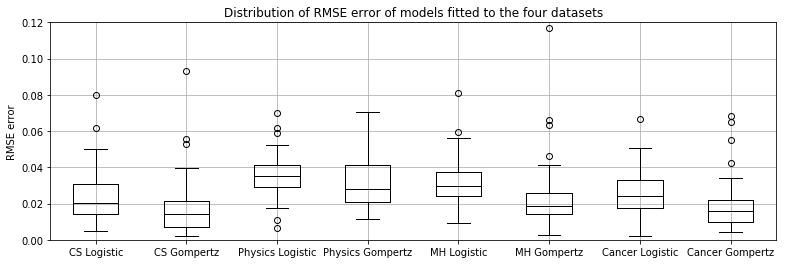

In [9]:
axs = pd.DataFrame({
    'CS Logistic': datasets['dblp_cs']['logistic']['single']['RMS'],
    'CS Gompertz': datasets['dblp_cs']['gompertz']['single']['RMS'],
    'Physics Logistic': datasets['arxiv_hep']['logistic']['single']['RMS'],
    'Physics Gompertz': datasets['arxiv_hep']['gompertz']['single']['RMS'],
    'MH Logistic': datasets['pubmed_mh']['logistic']['single']['RMS'],
    'MH Gompertz': datasets['pubmed_mh']['gompertz']['single']['RMS'],
    'Cancer Logistic': datasets['pubmed_cancer']['logistic']['single']['RMS'],
    'Cancer Gompertz': datasets['pubmed_cancer']['gompertz']['single']['RMS'],
}).boxplot(figsize=(13,4), return_type='dict')

[item.set_color('k') for item in axs['boxes']]
[item.set_color('k') for item in axs['whiskers']]
[item.set_color('k') for item in axs['medians']]

plt.suptitle("")
p = plt.gca()
p.set_ylabel('RMSE error')
p.set_title('Distribution of RMSE error of models fitted to the four datasets', fontsize=12)
p.set_ylim([0,0.12])

There is some variation across the datasets, although the Gompertz model is consistent in producing a lower median error than the Logistic model. It's worth noting also that the Particle Physics and Mental Health datasets are smaller than the Cancer and Computer Science ones. They also have higher error. 

### Calculation of trend duration

The Loglet Lab documentation (https://logletlab.com/loglet/documentation/index) contains a formula for the time taken for a Gompertz curve to go from 10% to 90% of its eventual maximum cumulative frequency ($\Delta t$). Their calculation is that

$\Delta t = -\frac{\ln(\ln(81))}{r}$


However, our observation was that this did not remotely describe the observed span of the fitted curves. We have therefore done the derivation ourselves and found that the correct parameterisation is:

$\Delta t = \frac{1}{\ln(-(\ln(0.9))-\ln(-\ln(0.1))}$

Unfortunately, the LogletLab initial parameter guesses are tailored to this incorrect parameterisation so it is much simpler to use it when fitting the curve (and irrelevant, except when it comes to calculating curve span). Therefore we use it, then convert to the correct value using the conversion factor below:

In [10]:
conversion_factor = -((np.log(-np.log(0.9))-np.log(-np.log(0.1)))/np.log(np.log(81)))

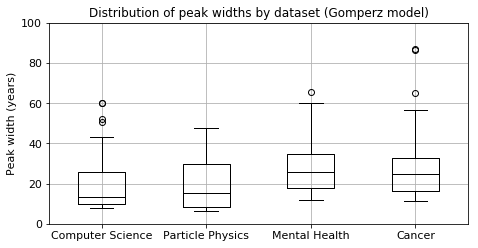

In [11]:
spans = pd.DataFrame({
    'Computer Science': datasets['dblp_cs']['gompertz']['single']['a']*conversion_factor,
    'Particle Physics': datasets['arxiv_hep']['gompertz']['single']['a']*conversion_factor,
    'Mental Health': datasets['pubmed_mh']['gompertz']['single']['a']*conversion_factor,
    'Cancer': datasets['pubmed_cancer']['gompertz']['single']['a']*conversion_factor
})


axs = spans.boxplot(figsize=(7.5,3.7),  return_type='dict', fontsize=11)

[item.set_color('k') for item in axs['boxes']]
[item.set_color('k') for item in axs['whiskers']]
[item.set_color('k') for item in axs['medians']]

#plt.figure(figsize=(6,3.7))
plt.suptitle("")
p = plt.gca()
p.set_ylabel('Peak width (years)', fontsize=11)
p.set_title('Distribution of peak widths by dataset (Gomperz model)', fontsize=12)
p.set_ylim([0,100])

plt.savefig(root+'images/curvespans.eps', format='eps', dpi=1200)

The data is quite skewed here...something to bear in mind when testing for significance later. 


### Median trend durations in different disciplines

In [12]:
for i , dataset_name in enumerate(dataset_names):
    print(dataset_titles[i], '| Median trend duration =', np.round(np.median(datasets[dataset_name]['gompertz']['single']['a']*conversion_factor),1), 'years')


Computer science (dblp) | Median trend duration = 25.8 years
Particle physics (arXiv) | Median trend duration = 15.1 years
Mental health (PubMed) | Median trend duration = 24.6 years
Cancer (PubMed) | Median trend duration = 13.4 years


### Testing for significance between disciplines

There are substantial differences between the median trend durations, with Computer Science and Particle Physics having shorter durations and the two PubMed datasets having longer ones. But are these significant? Since the data is somewhat skewed, we use Mood's median test to find p-values for the differences (Mood's median test does not require normal data).

In [13]:
for i in range(4):
    for j in range(i,4):
        if i == j:
            pass
        else:
            spans1 = datasets[dataset_names[i]]['gompertz']['single']['a']*conversion_factor
            spans2 = datasets[dataset_names[j]]['gompertz']['single']['a']*conversion_factor
            stat, p, med, tbl = scipy.stats.median_test(spans1, spans2)

            print(dataset_titles[i], 'vs', dataset_titles[j], 'p-value =', np.round(p,3))

Computer science (dblp) vs Particle physics (arXiv) p-value = 0.003
Computer science (dblp) vs Mental health (PubMed) p-value = 0.841
Computer science (dblp) vs Cancer (PubMed) p-value = 0.009
Particle physics (arXiv) vs Mental health (PubMed) p-value = 0.072
Particle physics (arXiv) vs Cancer (PubMed) p-value = 0.549
Mental health (PubMed) vs Cancer (PubMed) p-value = 0.028


So the p value between Particle Physics and Computer Science is not acceptable, and neither is the p-value between Mental Health and Cancer. How about between these two groups?

In [14]:
dblp_spans = datasets['dblp_cs']['gompertz']['single']['a']*conversion_factor
cancer_spans = datasets['pubmed_cancer']['gompertz']['single']['a']*conversion_factor
arxiv_spans = datasets['arxiv_hep']['gompertz']['single']['a']*conversion_factor
mh_spans = datasets['pubmed_mh']['gompertz']['single']['a']*conversion_factor

stat, p, med, tbl = scipy.stats.median_test(pd.concat([arxiv_spans, dblp_spans]), pd.concat([cancer_spans, mh_spans]))

print(np.round(p,5))

0.00013


This difference IS significant!

### Double-peaking curves

We now move to analyse the data for double-peaked curves. For each term, we have calculated the error when two peaks are fitted, and the error when a single peak is fitted. We can compare the error in each case like so:

In [15]:
print('Neural networks, single peak | error =', np.round(datasets['dblp_cs']['gompertz']['single']['RMS']['neural network'],3))
print('Neural networks, double peak| error =', np.round(datasets['dblp_cs']['gompertz']['double']['RMS']['neural network'],3))

Neural networks, single peak | error = 0.031
Neural networks, double peak| error = 0.011


Where do we see the largest reductions?

In [16]:
difference = datasets['dblp_cs']['gompertz']['single']['RMS']-datasets['dblp_cs']['gompertz']['double']['RMS']
for term in difference.index:
    if difference[term] > 0.015:
        print(term, np.round(difference[term], 3))

neural network 0.02
machine learning 0.02
convolutional neural network,cnn 0.085
discrete mathematics 0.031
parallel 0.024
recurrent 0.026
embeddings 0.037
learning model 0.024


### Examples of double peaking curves

So in some cases there is an error reduction from moving from the single- to double-peaked model. What does this look like in practice?

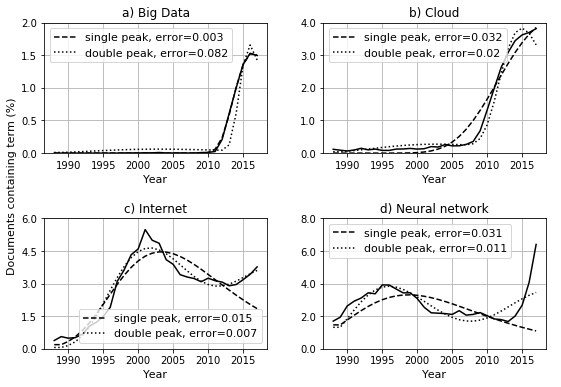

In [17]:
x = range(1988,2018)

# Load the original data
df = pickle.load(open(root+'clusters/dblp_cs.p', 'rb'))

# Choose four example terms
terms = ['big data', 'cloud', 'internet', 'neural network']
titles = ['a) Big Data', 'b) Cloud', 'c) Internet', 'd) Neural network']

# We want to set an overall y-label. The solution(found at https://stackoverflow.com/a/27430940) is to 
# create an overall plot first, give it a y-label, then hide it by removing plot borders.
fig, big_ax = plt.subplots(figsize=(9.0, 6.0) , nrows=1, ncols=1, sharex=True) 
big_ax.tick_params(labelcolor=(1,1,1,0.0), top=False, bottom=False, left=False, right=False)
big_ax._frameon = False
big_ax.set_ylabel("Documents containing term (%)", fontsize=11)


axs = [0,0,0,0]
axs[0]=fig.add_subplot(2,2,1)
axs[1]=fig.add_subplot(2,2,2)
axs[2]=fig.add_subplot(2,2,3)
axs[3]=fig.add_subplot(2,2,4)
fig.subplots_adjust(wspace=0.25, hspace=0.5, right=0.9)

# Set y limits manually beforehand
limits = [2, 4, 6, 8]


for i, term in enumerate(terms):
    # Get the proportional document frequency of the term over time
    y_proportional = df[term].divide(document_count_per_year['dblp_cs'])
    
    # Multiply by 100 when plotting so that it reads as a percentage
    axs[i].plot(x, 100*y_proportional, color='k')
    
    axs[i].grid(True)
    axs[i].set_xlabel("Year", fontsize=11)
    axs[i].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    
    # Now plot single and double peaked models
    for j, curve_type in enumerate(['single', 'double']):
        if curve_type == 'single':
            y_overall = logletlab.calculate_series(x, 
                                datasets['dblp_cs']['gompertz'][curve_type]['a'][term],
                                datasets['dblp_cs']['gompertz'][curve_type]['k'][term],
                                datasets['dblp_cs']['gompertz'][curve_type]['b'][term],
                                'gompertz')
            
            y_overall = detransform_fit(y_proportional.cumsum(), y_overall, 'dblp_cs')
            error = datasets['dblp_cs']['gompertz'][curve_type]['RMS'][term]
            axs[i].plot(x, 100*y_overall, color='k', linestyle='--', label="single peak, error="+str(np.round(error,3)))

        
        else:
            y_overall, y_1, y_2 = logletlab.calculate_series_double(x, 
                                  datasets['dblp_cs']['gompertz'][curve_type]['a1'][term],
                                  datasets['dblp_cs']['gompertz'][curve_type]['k1'][term],
                                  datasets['dblp_cs']['gompertz'][curve_type]['b1'][term],
                                  datasets['dblp_cs']['gompertz'][curve_type]['a2'][term],
                                  datasets['dblp_cs']['gompertz'][curve_type]['k2'][term],
                                  datasets['dblp_cs']['gompertz'][curve_type]['b2'][term],
                                  'gompertz')
            y_overall = detransform_fit(y_proportional.cumsum(), y_overall, 'dblp_cs')
            error = datasets['dblp_cs']['gompertz'][curve_type]['RMS'][term]
            axs[i].plot(x, 100*y_overall, color='k', linestyle=':', label="double peak, error="+str(np.round(error,3)))


        axs[i].set_title(titles[i], fontsize=12)
        axs[i].legend( fontsize=11)
        axs[i].set_ylim([0, limits[i]])


# We want the same number of y ticks for each axis so that it reads more neatly
axs[2].set_yticks([0, 1.5, 3, 4.5, 6])

fig.savefig(root+'images/doublepeaked.eps', format='eps', dpi=1200)



### Graphs of all four datasets

In this section we try to show as many graphs of fitted models as can reasonably fit on a page. The two functions used to make the graphs [below] are very hacky! However they work for this specific purpose.

In [39]:
def choose_ylimit(prevalence):
    '''
    This function works to find the most appropriate upper y limit to make the plots look good
    '''
    if max(prevalence) < 0.5:
        return 0.5
    elif max(prevalence) > 0.5 and max(prevalence) < 0.8:
        return 0.8
    elif max(prevalence) > 10 and max(prevalence) < 12:
        return 12
    elif max(prevalence) > 12 and  max(prevalence) < 15:
        return 15
    elif max(prevalence) > 15 and  max(prevalence) < 20:
        return 20
    else:
        return np.ceil(max(prevalence))
    
def prettyplot(df, dataset_name, gompertz_params, yplots, xplots, title, ylabel, xlabel, xlims, plot_titles):
    '''
    Plot a nicely formatted set of trends with their fitted models. This function is rather hacky and made
    for this specific purpose!
    '''
    fig, axs = plt.subplots(yplots, xplots)
    plt.subplots_adjust(right=1, hspace=0.5, wspace=0.25)
    plt.suptitle(title, fontsize=14)
    fig.subplots_adjust(top=0.95)
    fig.set_figheight(15)
    fig.set_figwidth(9)
    x = [int(i) for i in list(df.index)]

    for i, term in enumerate(df.columns[0:yplots*xplots]):
        prevalence = df[term].divide(document_count_per_year[dataset_name], axis=0)
        if plot_titles == None:
            title = term.split(',')[0]
        else:
            title = titles[i]
        
        # Now get the gompertz representation of it
        if gompertz_params['single']['RMS'][term]-gompertz_params['double']['RMS'][term] < 0.005:
            # Use the single peaked version
            y_overall = logletlab.calculate_series(x, 
                                         gompertz_params['single']['a'][term],
                                         gompertz_params['single']['k'][term],
                                         gompertz_params['single']['b'][term],
                                         'gompertz')
            y_overall = detransform_fit(prevalence.cumsum(), y_overall, dataset_name) 
            
        else:
            
            y_overall, y_1, y_2 = logletlab.calculate_series_double(x, 
                                         gompertz_params['double']['a1'][term],
                                         gompertz_params['double']['k1'][term],
                                         gompertz_params['double']['b1'][term],
                                         gompertz_params['double']['a2'][term],
                                         gompertz_params['double']['k2'][term],
                                         gompertz_params['double']['b2'][term],
                                         'gompertz')
            y_overall = detransform_fit(prevalence.cumsum(), y_overall, dataset_name)
            
        axs[int(np.floor((i/xplots)%yplots)), i%xplots].plot(x, 100*prevalence, color='k', ls='-', label=title)
        axs[int(np.floor((i/xplots)%yplots)), i%xplots].plot(x, 100*y_overall, color='k', ls='--', label='gompertz')
        axs[int(np.floor((i/xplots)%yplots)), i%xplots].grid()


        axs[int(np.floor((i/xplots)%yplots)), i%xplots].set_xlim(xlims[0], xlims[1])
        axs[int(np.floor((i/xplots)%yplots)), i%xplots].set_ylim(0,choose_ylimit(100*prevalence))
        axs[int(np.floor((i/xplots)%yplots)), i%xplots].set_title(title, fontsize=12)
        axs[int(np.floor((i/xplots)%yplots)), i%xplots].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        
        if i%yplots != yplots-1:
            axs[i%yplots, int(np.floor((i/yplots)%xplots))].set_xticklabels([])
            

    axs[5,0].set_ylabel(ylabel, fontsize=12)
    


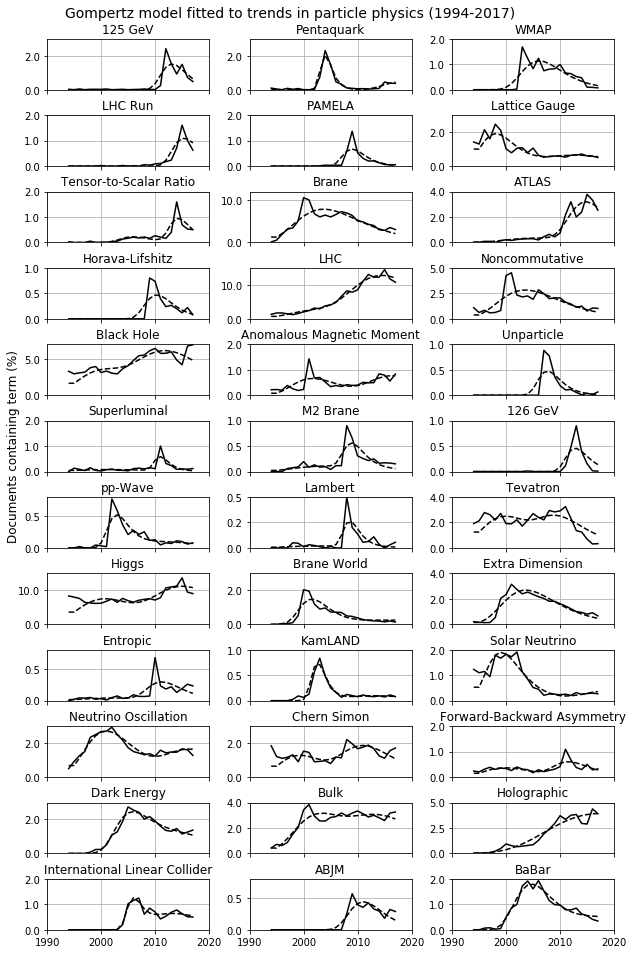

In [40]:
dataset_name = 'arxiv_hep'
df = pickle.load(open(root+'clusters/'+dataset_name+'.p', 'rb'))

titles = ['125 GeV', 'Pentaquark', 'WMAP', 'LHC Run', 'PAMELA', 'Lattice Gauge', 
 'Tensor-to-Scalar Ratio', 'Brane', 'ATLAS', 'Horava-Lifshitz', 'LHC', 
 'Noncommutative', 'Black Hole', 'Anomalous Magnetic Moment', 'Unparticle', 
 'Superluminal', 'M2 Brane', '126 GeV', 'pp-Wave', 'Lambert', 'Tevatron', 'Higgs', 
 'Brane World', 'Extra Dimension', 'Entropic', 'KamLAND', 'Solar Neutrino', 
 'Neutrino Oscillation', 'Chern Simon', 'Forward-Backward Asymmetry', 'Dark Energy', 
 'Bulk', 'Holographic', 'International Linear Collider', 'ABJM', 'BaBar']

prettyplot(df, 'arxiv_hep', datasets[dataset_name]['gompertz'],  12, 3, "Gompertz model fitted to trends in particle physics (1994-2017)", "Documents containing term (%)", None, [1990,2020], titles)

plt.savefig(root+'images/arxiv_hep.eps', format='eps', dpi=1200, bbox_inches='tight')

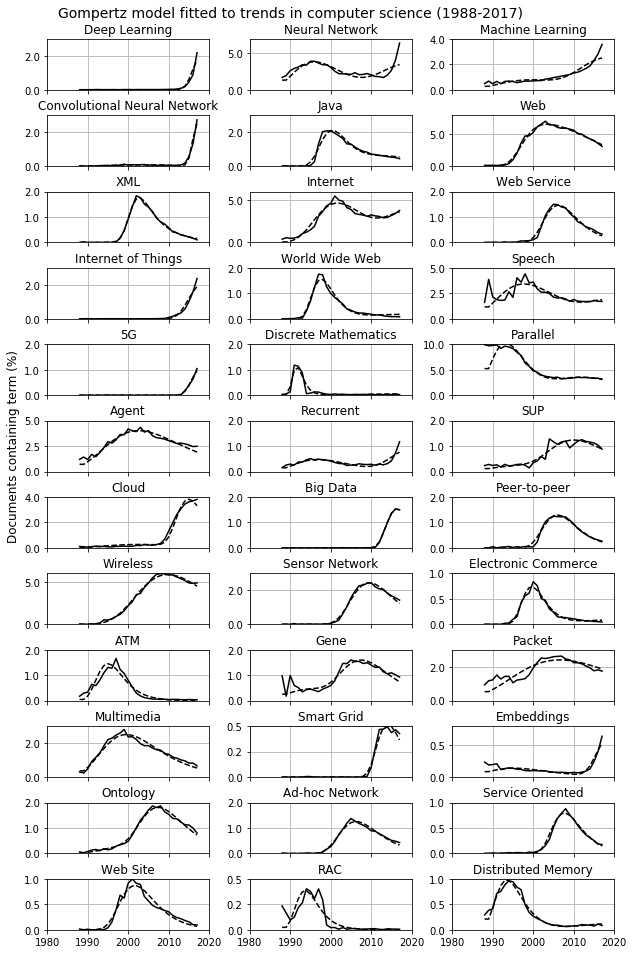

In [41]:
dataset_name = 'dblp_cs'
df = pickle.load(open(root+'clusters/'+dataset_name+'.p', 'rb'))

titles = ['Deep Learning', 'Neural Network', 'Machine Learning', 'Convolutional Neural Network', 
          'Java', 'Web', 'XML', 'Internet', 'Web Service', 'Internet of Things', 'World Wide Web', 
          'Speech', '5G', 'Discrete Mathematics', 'Parallel', 'Agent', 'Recurrent', 'SUP', 'Cloud', 
          'Big Data', 'Peer-to-peer', 'Wireless', 'Sensor Network', 'Electronic Commerce', 'ATM', 'Gene', 
          'Packet', 'Multimedia', 'Smart Grid', 'Embeddings', 'Ontology', 'Ad-hoc Network', 'Service Oriented', 
          'Web Site', 'RAC', 'Distributed Memory']

prettyplot(df, 'dblp_cs', datasets[dataset_name]['gompertz'],  12, 3, 'Gompertz model fitted to trends in computer science (1988-2017)', "Documents containing term (%)", None, [1980,2020], titles)
plt.savefig(root+'images/dblp_cs.eps', format='eps', dpi=1200, bbox_inches='tight')

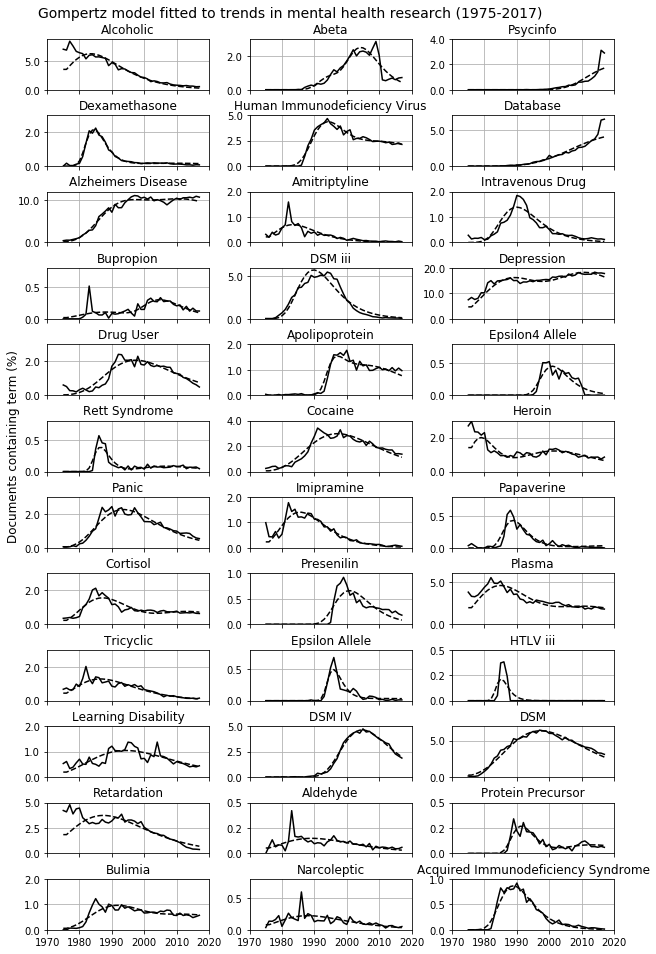

In [42]:
dataset_name = 'pubmed_mh'
df = pickle.load(open(root+'clusters/'+dataset_name+'.p', 'rb'))

titles = titles = ['Alcoholic', 'Abeta', 'Psycinfo', 'Dexamethasone', 'Human Immunodeficiency Virus', 
          'Database', 'Alzheimers Disease', 'Amitriptyline', 'Intravenous Drug', 'Bupropion', 
          'DSM iii', 'Depression', 'Drug User', 'Apolipoprotein', 'Epsilon4 Allele', 'Rett Syndrome', 
          'Cocaine', 'Heroin', 'Panic', 'Imipramine', 'Papaverine', 'Cortisol', 'Presenilin', 'Plasma', 
          'Tricyclic', 'Epsilon Allele', 'HTLV iii', 'Learning Disability', 'DSM IV', 'DSM', 
          'Retardation', 'Aldehyde', 'Protein Precursor', 'Bulimia', 'Narcoleptic', 'Acquired Immunodeficiency Syndrome']

prettyplot(df, 'pubmed_mh', datasets[dataset_name]['gompertz'],  12, 3, 'Gompertz model fitted to trends in mental health research (1975-2017)', 'Documents containing term (%)', None, [1970,2020], titles)
plt.savefig(root+'images/pubmed_mh.eps', format='eps', dpi=1200, bbox_inches='tight')

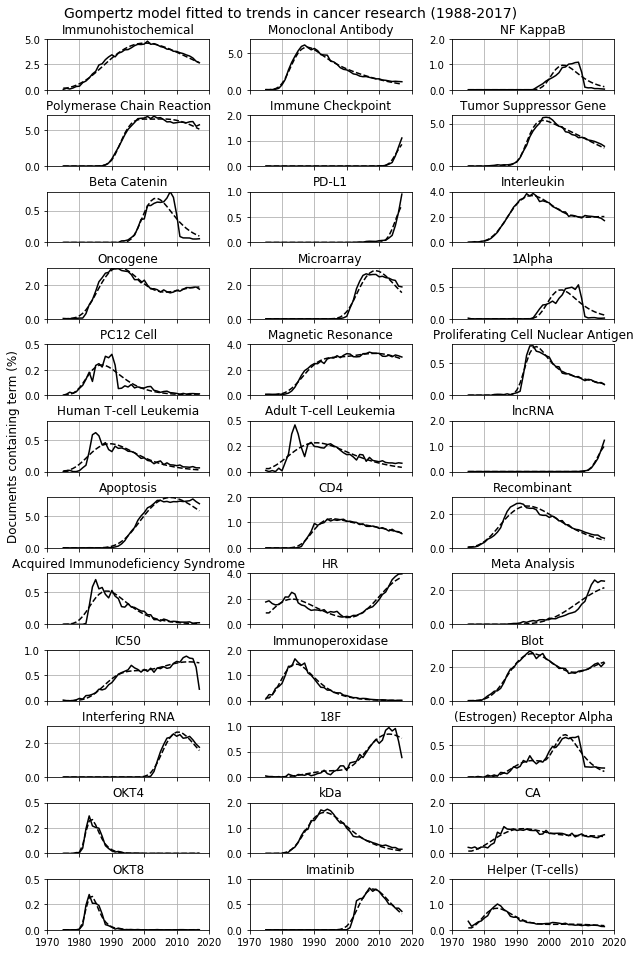

In [43]:
dataset_name = 'pubmed_cancer'
df = pickle.load(open(root+'clusters/'+dataset_name+'.p', 'rb'))

titles = ['Immunohistochemical', 'Monoclonal Antibody', 'NF KappaB', 'Polymerase Chain Reaction', 
          'Immune Checkpoint', 'Tumor Suppressor Gene', 'Beta Catenin', 'PD-L1', 'Interleukin', 
          'Oncogene', 'Microarray', '1Alpha', 'PC12 Cell', 'Magnetic Resonance', 
          'Proliferating Cell Nuclear Antigen', 'Human T-cell Leukemia', 'Adult T-cell Leukemia', 
          'lncRNA', 'Apoptosis', 'CD4', 'Recombinant', 'Acquired Immunodeficiency Syndrome', 
          'HR', 'Meta Analysis', 'IC50', 'Immunoperoxidase', 'Blot', 'Interfering RNA', '18F', 
          '(Estrogen) Receptor Alpha', 'OKT4', 'kDa', 'CA', 'OKT8', 'Imatinib', 'Helper (T-cells)']

prettyplot(df, 'pubmed_cancer', datasets[dataset_name]['gompertz'],  12, 3, 'Gompertz model fitted to trends in cancer research (1988-2017)', 'Documents containing term (%)', None, [1970,2020], titles)
plt.savefig(root+'images/pubmed_cancer.eps', format='eps', dpi=1200, bbox_inches='tight')